<div style="background: #DDE2FF;
            font-family: Bookerly;
            font-size: 16px; 
            font-weight: 100;
            padding: 20px 5px 0px 5px; 
            border: 10px solid #DDE2FF; 
            margin-left: 1px;
            margin-right: 1px;"
          
 <font color='blue'>**Chapter 31-9: PDE Solutions from Lattice Gas Dynamics**.
 
The lattice Boltzmann methods (LBM), originated from the lattice gas automata (LGA) method (Hardy-Pomeau-Pazzis and Frisch-Hasslacher-Pomeau models), is a class of computational fluid dynamics (CFD) methods for fluid simulation. Instead of solving the Navier–Stokes equations directly, a fluid density on a lattice is simulated with streaming and collision (relaxation) processes. Fictitious automata or microscopic cells in an array can be imagined as connected by links carrying a bounded number of discrete 
"particles" making up a "fluid". The method is versatile as the model fluid can straightforwardly be made to mimic common fluid behaviour like vapour/liquid coexistence. A master 
equation can be constructed to describe the evolution of average particle densities as a result of motion and collisions. Assuming slow variations with position 
and time, one can then write these particle densities as an expansion in terms of 
macroscopic quantities such as momentum density. The evolution of these quantities is determined by the original master equation. To the appropriate order in the 
expansion, certain cellular automaton models yield exactly the usual Navier-Stokes 
equations for hydrodynamics.  
</font>
</div>



In [ ]:
% Chapter 5
% LBM- 1-D, diffusion equation D1Q2
clear
m=101;
dx=1.0;
rho=zeros(m);f1=zeros(m);f2=zeros(m); flux=zeros(m);
x=zeros(m);
x(1)=0.0;
for i=1:m-1
    x(i+1)=x(i)+dx;
end
alpha=0.25;
omega=1/(alpha+0.5);
twall=1.0;
nstep=200;
for i=1:m
    f1(i)=0.5*rho(i);
    f2(i)=0.5*rho(i);
end
%Collision:
for k1=1:nstep
    for i=1:m
        feq=0.5*rho(i);
        f1(i)=(1-omega)*f1(i)+omega*feq;
        f2(i)=(1-omega)*f2(i)+omega*feq;
    end
    % Streaming:
    for i=1:m-1
        f1(m-i+1)=f1(m-i);
        f2(i)=f2(i+1);
    end
    %Boundary condition:
    f1(1)=twall-f2(1);
    f1(m)=f1(m-1);
    f2(m)=f2(m-1);
    for j=1:m

        rho(j)=f1(j)+f2(j);
    end
end
    %Flux:
    for k=1:m
    flux(k)=omega*(f1(k)-f2(k));
    end
figure(1)
plot(x,rho)
    title("Temperature")
    xlabel("X")
    ylabel("T")
figure(2)
plot(x,flux,"o")
    title("Flux, time step=200")
    xlabel("X")
    ylabel("Flux")

    
    
    
    
    
    
    
    
    
    
    
    

cavity_sa

In [ ]:
% A Lattice Boltzmann (single relaxation time) D2Q9 solver,
% with the Spalart Allmaras turbulence model, on a lid-driven cavity. 
% Cell centers (nodes) are placed on the boundaries. 
% Author: Robert Lee
% Email: rlee32@gatech.edu

clear;close all;clc;

addpath basic
addpath bc
addpath turbulence

% Algorithm steps:
% Initialize meso (f)
% Apply meso BCs
% Determine macro variables and apply macro BCs
% Loop:
%   Collide
%   Apply meso BCs
%   Stream
%   Apply meso BCs?
%   Determine macro variables and apply macro BCs

% Physical parameters.
L_p = 4; %1.1; % Cavity dimension. 
U_p = 1; %1.1; % Cavity lid velocity.
nu_p = 1.2e-3; % 1.586e-5; % Physical kinematic viscosity.
rho0 = 1;
% Discrete/numerical parameters.
nodes = 100;
dt = .002;
timesteps = 10000;
nutilde0 = 1e-5; % initial nutilde value (should be non-zero for seeding).

% Derived nondimensional parameters.
Re = L_p * U_p / nu_p;
disp(['Reynolds number: ' num2str(Re)]);
% Derived physical parameters.
t_p = L_p / U_p;
disp(['Physical time scale: ' num2str(t_p) ' s']);
% Derived discrete parameters.
dh = 1/(nodes-1);
nu_lb = dt / dh^2 / Re;
disp(['Lattice viscosity: ' num2str(nu_lb)]);
tau = 3*nu_lb + 0.5;
disp(['Original relaxation time: ' num2str(tau)]);
omega = 1 / tau;
disp(['Physical relaxation parameter: ' num2str(omega)]);
u_lb = dt / dh;
disp(['Lattice speed: ' num2str(u_lb)])

% Determine macro variables and apply macro BCs
% Initialize macro, then meso.
rho = rho0*ones(nodes,nodes);
u = zeros(nodes,nodes);
v = zeros(nodes,nodes);
u(end,2:end-1) = u_lb;
% Initialize.
f = compute_feq(rho,u,v);
% Apply meso BCs.
f = moving_wall_bc(f,'north',u_lb);
f = wall_bc(f,'south');
f = wall_bc(f,'east');
f = wall_bc(f,'west');
% Initialize turbulence stuff.
d = compute_wall_distances(nodes);
nutilde = nutilde0*ones(nodes,nodes);
[omega, nut, nutilde] = update_nut(nutilde,nu_lb,dt,dh,d,u,v);

% Main loop.
disp(['Running ' num2str(timesteps) ' timesteps...']);
for iter = 1:timesteps
    if (mod(iter,timesteps/10)==0)
        disp(['Ran ' num2str(iter) ' iterations']);
    end
    
    % Collision.
    f = collide_sa(f, u, v, rho, omega);
    
    % Apply meso BCs.
    f = moving_wall_bc(f,'north',u_lb);
    f = wall_bc(f,'south');
    f = wall_bc(f,'east');
    f = wall_bc(f,'west');

    % Streaming.
    f = stream(f);
    
    % Apply meso BCs.
    f = moving_wall_bc(f,'north',u_lb);
    f = wall_bc(f,'south');
    f = wall_bc(f,'east');
    f = wall_bc(f,'west');
    
    % Determine macro variables and apply macro BCs
    [u,v,rho] = reconstruct_macro_all(f);
    u(end,2:end-1) = u_lb;
    v(end,2:end-1) = 0;
    u(1,:) = 0;
    v(1,:) = 0;
    u(:,1) = 0;
    v(:,1) = 0;
    u(:,end) = 0;
    v(:,end) = 0;
    [omega, nut, nutilde] = update_nut(nutilde,nu_lb,dt,dh,d,u,v);
    
    % VISUALIZATION
    % Modified from Jonas Latt's cavity code on the Palabos website.
    if (mod(iter,10)==0)
        uu = sqrt(u.^2+v.^2) / u_lb;
%         imagesc(flipud(uu));
        imagesc(flipud(nut));
%         imagesc(flipud(omega));
        colorbar
        axis equal off; drawnow
    end
end
disp('Done!');



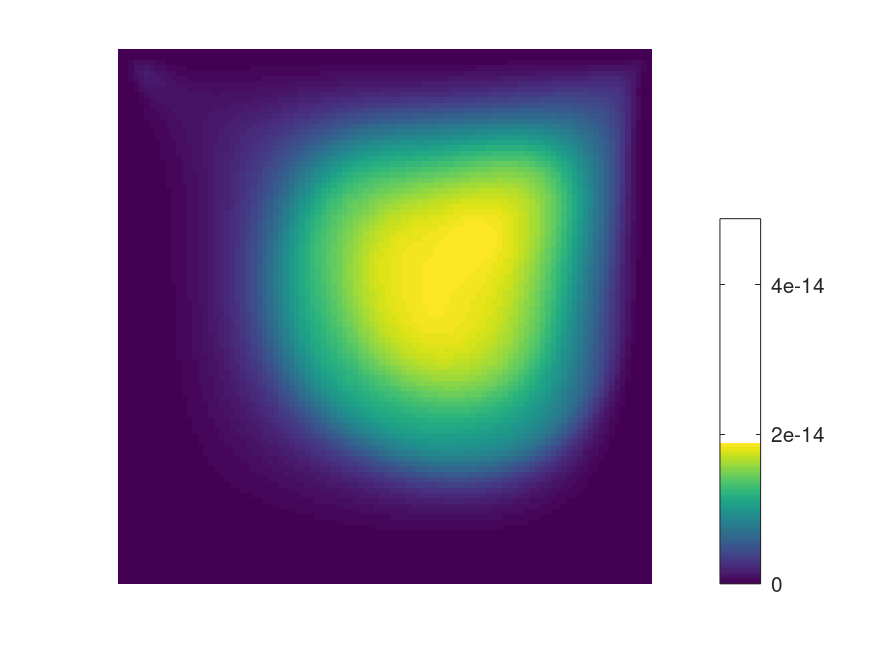

cavity_mohamad

In [ ]:
clear;close all;clc;

% D2Q9 solver
% This is almost a direct translation of the code found in the Mohamad
% textbook.

addpath basic
addpath post

% Numerical input parameters.
nodes = [100, 100]; % x nodes, y nodes.
dh = 1; % dh = dx = dy.
timesteps = 400;
dt = 1; % timestep.

% Physical input parameters.
u0 = 0.1;
rho0 = 5;
% Discrete parameters.
alpha = 0.01;
% Non-dimensional parameters.
Re = u0*nodes(1)/alpha;
disp(['Reynolds number: ' num2str(Re)]);

% Lattice link constants.
w = zeros(9,1);
w(1) = 4/9;
w(2:5) = 1/9;
w(6:9) = 1/36;
c = zeros(9,2);
c(1,:) = [0, 0];
c(2,:) = [1, 0];
c(3,:) = [0, 1];
c(4,:) = [-1, 0];
c(5,:) = [0, -1];
c(6,:) = [1, 1];
c(7,:) = [-1, 1];
c(8,:) = [-1, -1];
c(9,:) = [1, -1];

% Derived inputs.
omega = 1 / ( 3*alpha + 0.5 );

% Initialize.
rho = rho0*ones(nodes(2),nodes(1));
u = zeros(nodes(2),nodes(1));
v = zeros(nodes(2),nodes(1));
f = zeros(nodes(2),nodes(1),9);
feq = zeros(nodes(2),nodes(1),9);
% BC.
u(end,2:end-1) = u0;

% Main loop.
reconstruction_time = 0;
collision_time = 0;
streaming_time = 0;
bc_time = 0;
for iter = 1:timesteps
    disp(['Running timestep ' num2str(iter)]);
    % Collision.
    tic;
    t1 = u.*u + v.*v;
    for k = 1:9
        t2 = c(k,1)*u + c(k,2)*v;
        feq(:,:,k) = w(k)*rho.*(1 + 3*t2 + 4.5*t2.^2 - 1.5*t1);
        f(:,:,k) = omega*feq(:,:,k)+(1-omega)*f(:,:,k);
    end
    collision_time = collision_time + toc;
    % Streaming.
    tic;
    f(:,2:end,2) = f(:,1:end-1,2); % East vector.
    f(2:end,:,3) = f(1:end-1,:,3); % North vector.
    f(:,1:end-1,4) = f(:,2:end,4); % West vector.
    f(1:end-1,:,5) = f(2:end,:,5); % South vector.
    f(2:end,2:end,6) = f(1:end-1,1:end-1,6); % Northeast vector.
    f(2:end,1:end-1,7) = f(1:end-1,2:end,7); % Northwest vector.
    f(1:end-1,1:end-1,8) = f(2:end,2:end,8); % Southwest vector.
    f(1:end-1,2:end,9) = f(2:end,1:end-1,9); % Southeast vector.
    streaming_time = streaming_time + toc;
    % BC.
    tic;
    f(:,1,2) = f(:,1,4); % West bounceback.
    f(:,1,6) = f(:,1,8); % West bounceback.
    f(:,1,9) = f(:,1,7); % West bounceback.
    f(:,end,4) = f(:,end,2); % East bounceback.
    f(:,end,8) = f(:,end,6); % East bounceback.
    f(:,end,7) = f(:,end,9); % East bounceback.
    f(1,:,3) = f(1,:,5); % South bounceback.
    f(1,:,6) = f(1,:,8); % South bounceback.
    f(1,:,7) = f(1,:,9); % South bounceback.
    rho_end = f(end,2:end-1,1) + f(end,2:end-1,2) + f(end,2:end-1,4) + ...
        2*( f(end,2:end-1,3) + f(end,2:end-1,7) + f(end,2:end-1,6) );
    f(end,2:end-1,5) = f(end,2:end-1,3); % North boundary (moving lid).
    f(end,2:end-1,9) = f(end,2:end-1,7) + (u0 / 6)*rho_end; % North boundary (moving lid).
    f(end,2:end-1,8) = f(end,2:end-1,6) - (u0 / 6)*rho_end; % North boundary (moving lid).
    bc_time = bc_time + toc;
    % Density and velocity reconstruction.
    tic;
    rho = sum(f,3);
    rho(end,2:end) = f(end,2:end,1) + f(end,2:end,2) + f(end,2:end,4) + ...
        2*( f(end,2:end,3) + f(end,2:end,7) + f(end,2:end,6) );
    u(2:end-1,2:end) = 0;
    v(2:end-1,2:end) = 0;
    for k = 1:9
        u(2:end-1,2:end) = u(2:end-1,2:end) + c(k,1)*f(2:end-1,2:end,k);
        v(2:end-1,2:end) = v(2:end-1,2:end) + c(k,2)*f(2:end-1,2:end,k);
    end
    u(2:end-1,2:end) = u(2:end-1,2:end) ./ rho(2:end-1,2:end);
    v(2:end-1,2:end) = v(2:end-1,2:end) ./ rho(2:end-1,2:end);
    reconstruction_time = reconstruction_time + toc;
end

% Timing outputs.
total_time = reconstruction_time + collision_time + streaming_time + bc_time;
disp(['Solution reconstruction time (s): ' num2str(reconstruction_time)]);
disp(['Collision time (s): ' num2str(collision_time)]);
disp(['Streaming time (s): ' num2str(streaming_time)]);
disp(['BC time (s): ' num2str(bc_time)]);
disp(['Solution reconstruction fraction: ' num2str(reconstruction_time/total_time)]);
disp(['Collision fraction: ' num2str(collision_time/total_time)]);
disp(['Streaming fraction: ' num2str(streaming_time/total_time)]);
disp(['BC fraction: ' num2str(bc_time/total_time)]);

% Streamfunction calculation.
strf = zeros(nodes(2),nodes(1));
for i = 2:nodes(1)
    rho_av = 0.5*( rho(1,i-1) + rho(1,i) );
    strf(1,i) = strf(1,i-1) - 0.5*rho_av*( v(1,i-1) + v(1,i) );
    for j = 2:nodes(2)
        rho_m = 0.5 * ( rho(j,i) + rho(j-1,i) );
        strf(j,i) = strf(j-1,i) + 0.5*rho_m*( u(j-1,i) + u(j,i) );
    end
end

% % Plotting results!
figure;
L = dh*[nodes(1)-1, nodes(2)-1] ; % x , y dimensions of physical domain.
x = linspace(0,L(1),nodes(1))';
y = linspace(0,L(2),nodes(2))';
[X, Y] = meshgrid(x,y);
contour(X, Y, strf);
title('Solution');
xlabel('x');
ylabel('y');


